In [1]:
schema = '20221101-7d'

In [2]:
import json
import pathlib

import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt

from halo_infinite_analysis import db

In [3]:
ROOT = pathlib.Path('C:/Users/acurt/source/halo-infinite-analysis')
CONFIG = json.loads((ROOT / 'config.json').read_text())

In [8]:
sql = """
    SELECT
        match_id,
        team_id,
        match_duration,
        game_variant_category,
        map_variant,
        game_variant,
        map_mode_pair,
        outcome,
        rank,
        score,
        personal_score,
        rounds_won,
        rounds_lost,
        rounds_tied,
        kills,
        deaths,
        assists,
        mmr,
        pre_match_csr,
        post_match_csr,
        kills_expected,
        deaths_expected
    FROM "20221101-7d".vw_team
    WHERE
        playlist = 'Ranked Arena' AND
        match_id IN (
            SELECT match_id
            FROM "20221101-7d".vw_team
            WHERE outcome != 'DidNotFinish'
            GROUP BY match_id
            HAVING count(team_id) = 2
        )
"""

with db.connect(**CONFIG['database']) as conn:
    df = pd.read_sql(sql, conn)

df.head()

C:\Users\acurt\AppData\Local\Temp\ipykernel_9076\1102181844.py:38: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(sql, conn)


,match_id,team_id,match_duration,game_variant_category,map_variant,game_variant,map_mode_pair,outcome,rank,score,...,rounds_lost,rounds_tied,kills,deaths,assists,mmr,pre_match_csr,post_match_csr,kills_expected,deaths_expected
0,24233,0,757.91530,CTF,Catalyst,Ranked:CTF,Ranked:CTF on Catalyst,Win,1,1,...,0,0,60,48,27,1111.65230,1101.75,1109.75,68.216300,59.980470
1,26645,1,584.43550,Strongholds,Recharge,Ranked:Strongholds,Ranked:Strongholds on Recharge,Loss,2,125,...,1,0,50,56,25,1472.02450,1469.50,1460.75,58.002550,57.837673
2,25921,1,748.15686,Strongholds,Recharge,Ranked:Strongholds,Ranked:Strongholds on Recharge,Win,1,250,...,0,0,63,77,27,1398.89700,1384.50,1378.75,72.337845,73.665650
3,39718,1,765.79376,Bastion,Recharge,Ranked:King of the Hill,Ranked:King of the Hill on Recharge,Loss,2,2,...,1,0,85,80,36,506.10773,355.50,352.00,76.333740,80.854950
4,23115,0,797.04210,Oddball,Live Fire,Ranked:Oddball,Ranked:Oddball on Live Fire,Loss,2,176,...,2,0,67,72,25,1010.93870,509.50,513.75,74.406620,68.281395


In [18]:
slayer = df[df['game_variant_category'] == 'Slayer']
# slayer['kda'] = slayer['kills'] - slayer['deaths'] + (slayer['assists'] / 3)
slayer = slayer[['match_id', 'team_id', 'mmr', 'pre_match_csr', 'score']]
t0 = slayer[slayer['team_id'] == 0]
t1 = slayer[slayer['team_id'] == 1]
matches = pd.merge(t0, t1, on='match_id', suffixes=['_0', '_1'])
matches['mmr'] = matches['mmr_0'] - matches['mmr_1']
matches['pre_match_csr'] = matches['pre_match_csr_0'] - matches['pre_match_csr_1']
matches['score'] = matches['score_0'] - matches['score_1']
matches = matches[['match_id', 'mmr', 'pre_match_csr', 'score']]
matches.head()

,match_id,mmr,pre_match_csr,score
0,27881,-9.08880,-7.75,-6
1,25124,-1.87986,16.50,15
2,32584,4.32160,70.50,-4
3,27635,4.40727,-175.50,-7
4,29028,-21.45965,-11.25,3


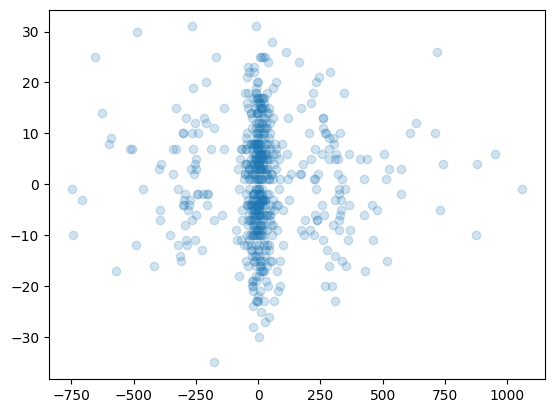

In [19]:
fig, ax = plt.subplots()

x = matches['pre_match_csr']
y = matches['score']

ax.scatter(x, y, alpha=0.2)

plt.show()